In [ ]:
# Stuff to run before this notebook

# local pc, make sure postgresql is running with the necessary data
# ssh -i ./fair_key -R 5432:localhost:5432 -L 8889:localhost:8889 -L 8887:localhost:8887 -L 8050:localhost:8050 name@host

# for conda env and vllm venv

# conda activate /raid/ggattiglia/magoh_ai/env
# source ./vllm-server/.venv/bin/activate

# LLM, needs conda and venv, replace cuda devices with gpus and hf token with your token (need to request permission to use model on huggingface first)
# CUDA_VISIBLE_DEVICES=0,1 HF_TOKEN=[hf_token] vllm serve --port 8001 google/gemma-3-27b-it --tensor-parallel-size 2 --gpu-memory-utilization 0.6

# mlflow, needs conda
# mlflow server --host 127.0.0.1 --port 8887

# NER server, needs conda and venv
# cd prompt_enhancing/models/custom-remote-models/src/magoh_ai_sup_server
# just run-server

In [ ]:
# the functions and code in this notebook should be in the code itself

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir(os.path.join(os.getcwd(), '..', '..', 'src'))
print("Current working directory:", os.getcwd())

Current working directory: /raid/ggattiglia/magoh_ai/zecchin_archaeo-extraction-prompt-eval/prompt_enhancing/src


In [3]:
from archaeo_super_prompt.dataset import MagohDataset, SamplingParams
import archaeo_super_prompt.modeling.train as training
import archaeo_super_prompt.modeling.predict as infering
import mlflow
import pandas as pd
from archaeo_super_prompt.visualization import mlflow_logging as mmlflow
from archaeo_super_prompt import visualization as visualizator
from archaeo_super_prompt.config.env import getenv_or_throw
from sklearn.pipeline import Pipeline
from sklearn import set_config

from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from archaeo_super_prompt.utils.cache import get_cache_dir_for

class LoadScans(BaseEstimator, TransformerMixin):
    def __init__(self, cache_csv: Path):
        self.cache_csv = Path(cache_csv)
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        scans = pd.read_csv(self.cache_csv)
        scans = scans.drop_duplicates(subset=["id"])
        return X.merge(scans, on="id", how="inner")

# cache location
CACHE_CSV = get_cache_dir_for("interim", "miscel") / "scans.csv"
SCANS_DF = pd.read_csv(CACHE_CSV)


In [18]:
EXP_NAME = "Complete training test"
mlflow.set_tracking_uri(f"http://{getenv_or_throw('MLFLOW_HOST')}:{getenv_or_throw('MLFLOW_PORT')}")
mlflow.set_experiment(EXP_NAME)
mlflow.dspy.autolog(log_compiles=True, log_evals=True, log_traces_from_compile=True)
pd.set_option('display.max_columns', None)
set_config(display="diagram")

from archaeo_super_prompt.utils.cache import get_cache_dir_for
store_dir = get_model_store_dir()
Path(store_dir).mkdir(parents=True, exist_ok=True)
print("Model store:", store_dir)

Model store: /raid/ggattiglia/magoh_ai/zecchin_archaeo-extraction-prompt-eval/prompt_enhancing/models/compiled


In [19]:
# HARD RESET OF CACHES / ARTIFACTS run this when fresh mlflow rerun is needed
import os, shutil, pathlib, urllib.parse, uuid
import mlflow

# wipe compiled DSPy programs used by extractors
from archaeo_super_prompt.utils.result import get_model_store_dir
shutil.rmtree(get_model_store_dir(), ignore_errors=True)

# wipe joblib / skdag caches inside project cache dirs
from archaeo_super_prompt.utils.cache import get_cache_dir_for
for scope in ["external","internal","interim","miscel","thesaurus","raw"]:
    try:
        base = get_cache_dir_for(scope)
    except Exception:
        continue
    if not base.exists(): 
        continue
    for p in base.rglob("*"):
        if p.is_dir() and any(k in p.name for k in ("joblib","skdag","__joblib_cache__")):
            shutil.rmtree(p, ignore_errors=True)

fresh_dir = pathlib.Path.cwd() / f"mlruns_fresh_{uuid.uuid4().hex[:6]}"
fresh_dir.mkdir(parents=True, exist_ok=True)
mlflow.set_tracking_uri(f"http://{getenv_or_throw('MLFLOW_HOST')}:{getenv_or_throw('MLFLOW_PORT')}")
mlflow.set_experiment(f"fresh-{uuid.uuid4().hex[:6]}")
mlflow.dspy.autolog(log_compiles=True, log_evals=True, log_traces_from_compile=True)
pd.set_option('display.max_columns', None)
set_config(display="diagram")

store_dir = get_model_store_dir()
Path(store_dir).mkdir(parents=True, exist_ok=True)
print("Model store:", store_dir)

2025/09/03 14:01:29 INFO mlflow.tracking.fluent: Experiment with name 'fresh-0773fa' does not exist. Creating a new experiment.


Model store: /raid/ggattiglia/magoh_ai/zecchin_archaeo-extraction-prompt-eval/prompt_enhancing/models/compiled


In [5]:
from archaeo_super_prompt.dataset import MagohDataset

selected_ids = set(map(int, SCANS_DF["id"].dropna().tolist()))
ds = MagohDataset(selected_ids)

inputs = ds.files.merge(SCANS_DF[["id"]].drop_duplicates(), on="id", how="inner")
train_inputs, eval_inputs = inputs.iloc[:10], inputs.iloc[10:]


In [6]:
import os, importlib

#delete openai in env if present, we have a local model
for k in ("OPENAI_BASE_URL", "OPENAI_API_BASE"):
    os.environ.pop(k, None)

#should be moved to env
os.environ["VLLM_SERVER_BASE_URL"] = "http://127.0.0.1:8001/v1"
#dspy seems to fall back to openai in case of errors, this is a dummy key
os.environ["OPENAI_API_KEY"] = "sk-local"

from archaeo_super_prompt.modeling.struct_extract import language_model as lm_provider_mod
from archaeo_super_prompt.modeling.struct_extract import field_extractor as fe
lm_provider_mod = importlib.reload(lm_provider_mod)
fe = importlib.reload(fe)

import pandas as pd
from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from archaeo_super_prompt.utils.cache import get_cache_dir_for
from archaeo_super_prompt.modeling import pdf_to_text
import ast

CACHE_CSV = get_cache_dir_for("interim", "miscel") / "scans.csv"

def _as_list(v):
    if isinstance(v, list): return v
    if pd.isna(v): return []
    if isinstance(v, str):
        s=v.strip()
        if s and s[0] in "[{(":
            try:
                x=ast.literal_eval(s)
                return x if isinstance(x, list) else [x]
            except Exception:
                return [v]
        return [v]
    return [v]

def _as_str_list(v):
    return [str(x) for x in _as_list(v)]

def _as_int_list(v):
    out=[]
    for x in _as_list(v):
        try:
            out.append(int(x))
        except Exception:
            try:
                out.append(int(float(x)))
            except Exception:
                pass
    return out

class LoadScans(BaseEstimator, TransformerMixin):
    def __init__(self, cache_csv: str | Path):
        self.cache_csv = Path(cache_csv)
        self._df = None
    def fit(self, X, y=None):
        df = pd.read_csv(self.cache_csv)
        if "id" in df.columns:
            df["id"] = df["id"].astype("int64").astype(int)
        if "chunk_type" in df.columns:
            df["chunk_type"] = df["chunk_type"].apply(_as_str_list)
        if "chunk_page_position" in df.columns:
            df["chunk_page_position"] = df["chunk_page_position"].apply(_as_int_list)
        if "identified_thesaurus" in df.columns:
            df["identified_thesaurus"] = df["identified_thesaurus"].apply(_as_int_list)
        if "named_entities" in df.columns:
            df["named_entities"] = df["named_entities"].apply(_as_list)
        self._df = df
        return self
    def transform(self, X):
        X = X.copy()
        if "id" in X.columns:
            X["id"] = X["id"].astype(int)
        return X.merge(self._df, on="id", how="inner")

# replace vision lm with preprocessed scans
pdf_to_text.VLLM_Preprocessing = lambda **kw: LoadScans(CACHE_CSV)

training = importlib.reload(training)

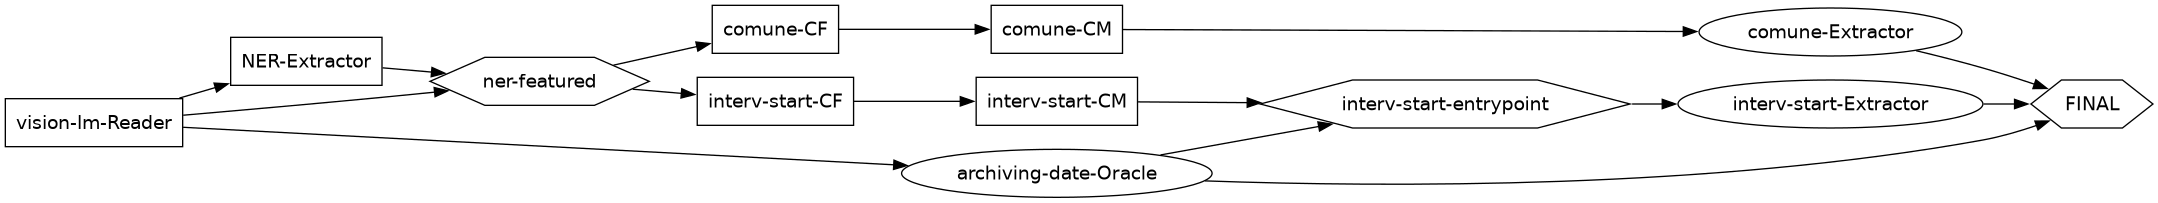

In [7]:
_base_parts = training.get_training_dag()
from archaeo_super_prompt.modeling import predict as infering
expected_final_pipeline = infering.build_complete_inference_dag(_base_parts)
expected_final_pipeline


In [8]:
import re, datetime, pandas as pd
from archaeo_super_prompt.modeling.struct_extract.extractors.archiving_date import ArchivingDateProvider, ArchivingDateOutputSchema

def _predict_safe(self, X):
    def parse(dp):
        if dp is None: return datetime.date(1900,1,1)
        if isinstance(dp, (datetime.date, datetime.datetime, pd.Timestamp)):
            return dp.date() if hasattr(dp, "date") else dp
        s = str(dp).strip()
        if s == "" or s.lower() in ("none", "nan", "nat"): return datetime.date(1900,1,1)
        for fmt in ("%Y-%m-%d","%d-%m-%Y","%d/%m/%Y","%Y/%m/%d","%d.%m.%Y","%Y.%m.%d"):
            try: return datetime.datetime.strptime(s, fmt).date()
            except Exception: pass
        parts = re.split(r"[-/\. ]+", s)
        try:
            if len(parts) >= 3:
                d, m, y = map(int, parts[:3])
                if y < 100: y += 2000
                return datetime.date(y, m, d)
        except Exception: pass
        m = re.search(r"(\d{4})", s)
        if m: return datetime.date(int(m.group(1)), 1, 1)
        return datetime.date(1900,1,1)
    rows = [{"id": a.id, "data_protocollo": parse(getattr(a, "building__Data_Protocollo", None))}
            for a in self._mds.get_answers(set(X["id"].to_list()))]
    return ArchivingDateOutputSchema.validate(pd.DataFrame(rows).set_index("id"))

ArchivingDateProvider.predict = _predict_safe


In [9]:
import re, calendar, datetime
import archaeo_super_prompt.modeling.struct_extract.extractors.intervention_date as ide
from archaeo_super_prompt.modeling.struct_extract.extractors.intervention_date import InterventionStartExtractor, ITALIAN_MONTHS, Data, DataInterventoInputData
from archaeo_super_prompt.modeling.struct_extract.extractors.comune import ComuneExtractor, ComuneInputData, Comune
from archaeo_super_prompt.dataset.thesauri import comune_province as cp

def load_comune_aligned():
    df = pd.read_csv(cp._get_comune_file())
    df = df[df["nome"].notnull() & df["provincia"].notnull()]
    return [(id_com, nome) for _, id_com, nome in df[["id_com","nome"]].itertuples()]

cp.load_comune = load_comune_aligned


DATE_RE = re.compile(r"\b(\d{1,2}[\/\.-]\d{1,2}[\/\.-]\d{2,4}|gennaio|febbraio|marzo|aprile|maggio|giugno|luglio|agosto|settembre|ottobre|novembre|dicembre)\b", re.I)

# remove bad ocr output
def _strip_tables_and_noise(s):
    s=re.sub(r"^\s*\d+\s*,\s*\d+\s*=\s*.*$", "", s, flags=re.M|re.S)
    s=re.sub(r"`-+`\s*", "", s)
    return s

# avoids going over max context window for long (and badly read) documents
def _focus_and_truncate(s, max_chars=20000):
    s=_strip_tables_and_noise(s)
    if len(s)<=max_chars: return s
    lines=s.splitlines()
    hits=[ln for ln in lines if DATE_RE.search(ln)]
    head="\n".join(lines[:4000])
    tail="\n".join(lines[-2000:])
    middle="\n".join(hits)[:8000]
    out="\n".join([head,middle,tail])
    return out[:max_chars]

# feed trimmed "fragmenti relazione" and fix month (went out of bounds)
def _to_dspy_input_patched(self, x):
    d=x.data_protocollo
    return DataInterventoInputData(
        fragmenti_relazione=_focus_and_truncate(x.merged_chunks),
        data_di_archiviazone=Data(
            giorno=int(getattr(d,"day",d.day)),
            mese=ITALIAN_MONTHS[int(getattr(d,"month",d.month))-1],
            anno=int(getattr(d,"year",d.year)),
        ),
    )
# replace intervention start extractor to not crash when context is too large
InterventionStartExtractor._to_dspy_input = _to_dspy_input_patched

# fixes for invalid model outputs that broke the pipeline
def _as_int(x,d): 
    try: return int(x)
    except Exception: return d
def _clamp_month(m):
    m=_as_int(m,1)
    return 1 if m<1 else 12 if m>12 else m
def _clamp_day(y,m,d):
    y=_as_int(y,1900); m=_clamp_month(m); d=_as_int(d,1)
    last=calendar.monthrange(max(1,y),m)[1]
    return 1 if d<1 else last if d>last else d
def _get_min_date_safe(o):
    y=_as_int(getattr(o,"start_year",1900),1900)
    m=_clamp_month(getattr(o,"start_month",1))
    d=_clamp_day(y,m,getattr(o,"start_day",1))
    return datetime.date(y,m,d)
def _get_max_date_safe(o):
    y=getattr(o,"end_year",None)
    if y is None: y=getattr(o,"start_year",1900)
    y=_as_int(y,1900)
    m=_clamp_month(getattr(o,"end_month",12))
    d=_clamp_day(y,m,getattr(o,"end_day",28))
    return datetime.date(y,m,d)
ide._get_min_date = _get_min_date_safe
ide._get_max_date = _get_max_date_safe

# comune fixing section

def _read_comuni_tables_strict():
    comuni = pd.read_csv(cp._get_comune_file())[
        ["id_com", "nome", "provincia"]
    ].rename(columns={"id_com":"comune_id","nome":"name","provincia":"province_id"})
    comuni = comuni.dropna(subset=["name","province_id"]).copy()
    comuni["comune_id"] = comuni["comune_id"].astype(int)
    comuni["province_id"] = comuni["province_id"].astype(int)

    # drop duplicated comuni keeping the first occurrence
    dups = comuni["comune_id"].duplicated(keep="first").sum()
    if dups:
        print(f"[warn] dropping {dups} duplicated comuni by comune_id")
        comuni = comuni.drop_duplicates(subset=["comune_id"], keep="first")

    province = pd.read_csv(cp._get_provincie_file())[
        ["id_prov","nome","sigla"]
    ].rename(columns={"id_prov":"province_id","nome":"province_name"})
    province["province_id"] = province["province_id"].astype(int)
    province = province.drop_duplicates(subset=["province_id"], keep="first")

    # each comune refers to exactly one province
    merged = comuni.merge(
        province[["province_id","province_name","sigla"]],
        on="province_id",
        how="left",
        validate="m:1",   # raise if a province_id maps to multiple province rows
        copy=False,
    )

    comuni = comuni.set_index("comune_id").sort_index()
    merged = merged.set_index("comune_id").sort_index()
    return comuni, merged

_COMUNI, _MERGED = _read_comuni_tables_strict()
_POS2ID = _COMUNI.index.to_list()

_FIELDS = set(Comune.model_fields.keys())

def _mk_from_pos(pos: int):
    if not (0 <= pos < len(_POS2ID)):
        return None
    cid = _POS2ID[pos]
    if cid not in _MERGED.index:
        return None
    # scalar gets:
    name = str(_MERGED.at[cid, "name"])
    prov_name = str(_MERGED.at[cid, "province_name"])
    sigla = str(_MERGED.at[cid, "sigla"])
    kw = {}
    if "citta_nome" in _FIELDS:      kw["citta_nome"] = name
    if "provicia_nome" in _FIELDS:   kw["provicia_nome"] = prov_name
    if "provincia_sigla" in _FIELDS: kw["provincia_sigla"] = sigla
    if "id" in _FIELDS:              kw["id"] = int(cid)
    # not sure if name or nome is used
    if "nome" in _FIELDS and "citta_nome" not in _FIELDS: kw["nome"] = name
    if "name" in _FIELDS and "citta_nome" not in _FIELDS: kw["name"] = name
    return Comune(**kw)

def _comune_to_dspy_input(self, x):
    pos_list = getattr(x, "identified_thesaurus", None) or getattr(x, "possibili_comuni", None) or []
    if not isinstance(pos_list, list): pos_list = [pos_list]
    pos_list = [int(v) for v in pos_list if str(v).isdigit()]
    cands = [c for c in (_mk_from_pos(p) for p in pos_list) if c is not None]
    return ComuneInputData(
        fragmenti_relazione=getattr(x, "merged_chunks", ""),
        possibili_comuni=cands,
    )

# replace comune extractor code here because the original didn't work
ComuneExtractor._to_dspy_input = _comune_to_dspy_input

In [14]:
from archaeo_super_prompt.modeling import predict as infering
with mlflow.start_run():
    trained_dag_parts = training.train_from_scratch(train_inputs, ds)
    per_field_scores, detailed_results = infering.score_dag(trained_dag_parts, eval_inputs, ds)


NER analysing:   0%|                                                   | 0/4 [00:00<?, ?Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  25%|██████████▊                                | 1/4 [00:00<00:02,  1.15Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  50%|█████████████████████▌                     | 2/4 [00:01<00:01,  1.28Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  75%|████████████████████████████████▎          | 3/4 [00:02<00:00,  1.28Fraction of total text chunks/s]

Fetching the transformers model


Gathering filtered chunks: 100%|██████████████████████████████████████████████| 9/9 [00:00<00:00, 2243.34intervention/s]
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING MEDIUM AUTO RUN SETTINGS:
num_trials: 18
minibatch: False
num_fewshot_candidates: 12
num_instruct_candidates: 6
valset size: 7

2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=12 sets of demonstrations...


Bootstrapping set 1/12
Bootstrapping set 2/12
Bootstrapping set 3/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 410.32it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 461.39it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 540.12it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 510.72it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 7/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 507.29it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 8/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 503.73it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 9/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 558.57it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 10/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 484.11it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 11/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 569.18it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 12/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 538.94it/s]
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=6 instructions...

2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Degli framenti datti di relazione archeologiche, stima il momento di partenza dell'indagine in una finestra de due date, con un precisione al giorno, al mese o all'anno più vicino. Se non ci sono molte informazione, ritorna almeno una finestra prima di la data di archiv

Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 5.20 / 7 (74.3%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3825.92it/s]

2025/09/03 13:26:57 INFO dspy.evaluate.evaluate: Average Metric: 5.2 / 7 (74.3%)
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 74.29

/raid/ggattiglia/magoh_ai/env/lib/python3.13/site-packages/optuna/_experimental.py:32: ExperimentalWarning:

Argument ``multivariate`` is an experimental feature. The interface can change in the future.

2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 18 =====



Average Metric: 4.60 / 7 (65.7%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3762.19it/s]

2025/09/03 13:26:57 INFO dspy.evaluate.evaluate: Average Metric: 4.6 / 7 (65.7%)
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 6'].
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71]
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 18 =====



Average Metric: 5.18 / 7 (74.0%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3761.71it/s]

2025/09/03 13:26:57 INFO dspy.evaluate.evaluate: Average Metric: 5.18 / 7 (74.0%)
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.0 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 2'].
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0]
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 18 =====



Average Metric: 5.20 / 7 (74.3%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3296.67it/s]

2025/09/03 13:26:57 INFO dspy.evaluate.evaluate: Average Metric: 5.2 / 7 (74.3%)
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 6'].
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29]
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 18 =====



Average Metric: 4.63 / 7 (66.1%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3494.42it/s]

2025/09/03 13:26:57 INFO dspy.evaluate.evaluate: Average Metric: 4.63 / 7 (66.1%)
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 66.14 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 4'].
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14]
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 18 =====



Average Metric: 4.63 / 7 (66.1%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3770.89it/s]

2025/09/03 13:26:57 INFO dspy.evaluate.evaluate: Average Metric: 4.63 / 7 (66.1%)


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 66.14 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 5'].
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14]
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 18 =====


Average Metric: 5.18 / 7 (74.0%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3825.92it/s]

2025/09/03 13:26:57 INFO dspy.evaluate.evaluate: Average Metric: 5.18 / 7 (74.0%)
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.0 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 6'].
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0]


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 8 / 18 =====


Average Metric: 4.30 / 7 (61.4%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3806.08it/s]

2025/09/03 13:26:57 INFO dspy.evaluate.evaluate: Average Metric: 4.3 / 7 (61.4%)
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 61.43 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 1'].


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43]
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 9 / 18 =====


Average Metric: 4.63 / 7 (66.1%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3837.42it/s]

2025/09/03 13:26:57 INFO dspy.evaluate.evaluate: Average Metric: 4.63 / 7 (66.1%)
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 66.14 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 3'].
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43, 66.14]
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 10 / 18 =====



Average Metric: 4.63 / 7 (66.1%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3235.63it/s]

2025/09/03 13:26:57 INFO dspy.evaluate.evaluate: Average Metric: 4.63 / 7 (66.1%)
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 66.14 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 10'].
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43, 66.14, 66.14]
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 11 / 18 =====



Average Metric: 5.20 / 7 (74.3%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3344.74it/s]

2025/09/03 13:26:57 INFO dspy.evaluate.evaluate: Average Metric: 5.2 / 7 (74.3%)
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 0'].
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43, 66.14, 66.14, 74.29]
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:26:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 12 / 18 =====



Average Metric: 5.20 / 7 (74.3%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3853.54it/s]

2025/09/03 13:26:58 INFO dspy.evaluate.evaluate: Average Metric: 5.2 / 7 (74.3%)
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 6'].
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43, 66.14, 66.14, 74.29, 74.29]
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 18 =====



Average Metric: 5.20 / 7 (74.3%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3851.52it/s]

2025/09/03 13:26:58 INFO dspy.evaluate.evaluate: Average Metric: 5.2 / 7 (74.3%)
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 8'].
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43, 66.14, 66.14, 74.29, 74.29, 74.29]
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 14 / 18 =====



Average Metric: 5.20 / 7 (74.3%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3764.60it/s]

2025/09/03 13:26:58 INFO dspy.evaluate.evaluate: Average Metric: 5.2 / 7 (74.3%)
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 9'].
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43, 66.14, 66.14, 74.29, 74.29, 74.29, 74.29]
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 15 / 18 =====



Average Metric: 5.20 / 7 (74.3%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3840.44it/s]

2025/09/03 13:26:58 INFO dspy.evaluate.evaluate: Average Metric: 5.2 / 7 (74.3%)
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 7'].
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43, 66.14, 66.14, 74.29, 74.29, 74.29, 74.29, 74.29]
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 16 / 18 =====



Average Metric: 4.60 / 7 (65.7%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3856.58it/s]

2025/09/03 13:26:58 INFO dspy.evaluate.evaluate: Average Metric: 4.6 / 7 (65.7%)
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 0'].
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43, 66.14, 66.14, 74.29, 74.29, 74.29, 74.29, 74.29, 65.71]
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 17 / 18 =====



Average Metric: 5.20 / 7 (74.3%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3359.67it/s]

2025/09/03 13:26:58 INFO dspy.evaluate.evaluate: Average Metric: 5.2 / 7 (74.3%)
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 74.29 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 11'].
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43, 66.14, 66.14, 74.29, 74.29, 74.29, 74.29, 74.29, 65.71, 74.29]
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 18 / 18 =====



Average Metric: 4.30 / 7 (61.4%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3779.63it/s]

2025/09/03 13:26:58 INFO dspy.evaluate.evaluate: Average Metric: 4.3 / 7 (61.4%)
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 61.43 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 0'].
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43, 66.14, 66.14, 74.29, 74.29, 74.29, 74.29, 74.29, 65.71, 74.29, 61.43]
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 19 / 18 =====



Average Metric: 4.63 / 7 (66.1%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3823.43it/s]

2025/09/03 13:26:58 INFO dspy.evaluate.evaluate: Average Metric: 4.63 / 7 (66.1%)
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 66.14 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [74.29, 65.71, 74.0, 74.29, 66.14, 66.14, 74.0, 61.43, 66.14, 66.14, 74.29, 74.29, 74.29, 74.29, 74.29, 65.71, 74.29, 61.43, 66.14]
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 74.29
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 74.29!


2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING MEDIUM AUTO RUN SETTINGS:
num_trials: 18
minibatch: False
num_fewshot_candidates: 12
num_instruct_candidates: 6
valset size: 7

2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/09/03 13:26:58 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=12 sets of demonstrations...


Bootstrapping set 1/12
Bootstrapping set 2/12
Bootstrapping set 3/12


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.10s/it]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 4/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 800.36it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 5/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 894.50it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 6/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 951.31it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 7/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 937.27it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 8/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 887.40it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 9/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 914.89it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 10/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 910.62it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 11/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 916.09it/s]


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.
Bootstrapping set 12/12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 934.66it/s]
2025/09/03 13:27:14 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/09/03 13:27:14 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.


Bootstrapped 0 full traces after 1 examples for up to 1 rounds, amounting to 2 attempts.


2025/09/03 13:27:29 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=6 instructions...

2025/09/03 13:27:47 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/09/03 13:27:47 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Identifica il unico comune in cui si sono svolti i lavori archeologici descritti in questi frammenti di relazione. I comuni possibili sono indicati.

2025/09/03 13:27:47 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Analizza attentamente i seguenti frammenti di relazione archeologica. Tra i comuni elencati, determina con precisione quale è il luogo in cui si sono svolti gli scavi o le ricerche descritte. Fornisci una spiegazione dettagliata del tuo ragionamento, indicando quali elementi testuali ti hanno portato a questa conclusione. Infine, specifica il comune e la relativa provincia.

2025/09/03 13:27:47 INFO dspy.teleprompt.mipro_optimizer_v2: 2: You are an expert archaeologist tasked with identifying the location of archaeological

Average Metric: 4.00 / 7 (57.1%): 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.56s/it]

2025/09/03 13:27:58 INFO dspy.evaluate.evaluate: Average Metric: 4.0 / 7 (57.1%)
2025/09/03 13:27:58 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 57.14

2025/09/03 13:27:58 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 18 =====



Average Metric: 4.60 / 7 (65.7%): 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.55s/it]

2025/09/03 13:28:09 INFO dspy.evaluate.evaluate: Average Metric: 4.6 / 7 (65.7%)
2025/09/03 13:28:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 65.71
2025/09/03 13:28:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 6'].
2025/09/03 13:28:09 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71]
2025/09/03 13:28:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 65.71
2025/09/03 13:28:09 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:28:09 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 18 =====



Average Metric: 4.30 / 7 (61.4%): 100%|███████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]

2025/09/03 13:28:19 INFO dspy.evaluate.evaluate: Average Metric: 4.3 / 7 (61.4%)
2025/09/03 13:28:19 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 61.43 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 2'].
2025/09/03 13:28:19 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43]
2025/09/03 13:28:19 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 65.71
2025/09/03 13:28:19 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:28:19 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 18 =====



Average Metric: 4.60 / 7 (65.7%): 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]

2025/09/03 13:28:29 INFO dspy.evaluate.evaluate: Average Metric: 4.6 / 7 (65.7%)
2025/09/03 13:28:29 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 6'].
2025/09/03 13:28:29 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71]
2025/09/03 13:28:29 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 65.71
2025/09/03 13:28:29 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:28:29 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 18 =====



Average Metric: 4.60 / 7 (65.7%): 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.57s/it]

2025/09/03 13:28:40 INFO dspy.evaluate.evaluate: Average Metric: 4.6 / 7 (65.7%)
2025/09/03 13:28:40 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 4'].
2025/09/03 13:28:40 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71]
2025/09/03 13:28:40 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 65.71
2025/09/03 13:28:40 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:28:40 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 18 =====



Average Metric: 4.90 / 7 (70.0%): 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]

2025/09/03 13:28:51 INFO dspy.evaluate.evaluate: Average Metric: 4.9 / 7 (70.0%)
2025/09/03 13:28:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 70.0
2025/09/03 13:28:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 70.0 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 5'].
2025/09/03 13:28:51 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0]
2025/09/03 13:28:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 70.0
2025/09/03 13:28:51 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:28:51 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 18 =====



Average Metric: 5.60 / 7 (80.0%): 100%|███████████████████████████████████████████████████| 7/7 [00:11<00:00,  1.60s/it]

2025/09/03 13:29:02 INFO dspy.evaluate.evaluate: Average Metric: 5.6 / 7 (80.0%)
2025/09/03 13:29:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 80.0
2025/09/03 13:29:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 6'].
2025/09/03 13:29:02 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0]
2025/09/03 13:29:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:02 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:29:02 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 8 / 18 =====



Average Metric: 4.30 / 7 (61.4%): 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]

2025/09/03 13:29:12 INFO dspy.evaluate.evaluate: Average Metric: 4.3 / 7 (61.4%)
2025/09/03 13:29:12 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 61.43 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 1'].
2025/09/03 13:29:12 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43]
2025/09/03 13:29:12 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:12 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:29:12 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 9 / 18 =====



Average Metric: 4.30 / 7 (61.4%): 100%|███████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]

2025/09/03 13:29:23 INFO dspy.evaluate.evaluate: Average Metric: 4.3 / 7 (61.4%)
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 61.43 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 3'].
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43, 61.43]
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 10 / 18 =====



Average Metric: 4.90 / 7 (70.0%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 4034.65it/s]

2025/09/03 13:29:23 INFO dspy.evaluate.evaluate: Average Metric: 4.9 / 7 (70.0%)
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 70.0 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 10'].
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43, 61.43, 70.0]
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 11 / 18 =====



Average Metric: 4.30 / 7 (61.4%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3840.44it/s]

2025/09/03 13:29:23 INFO dspy.evaluate.evaluate: Average Metric: 4.3 / 7 (61.4%)
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 61.43 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 11'].
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43, 61.43, 70.0, 61.43]
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 12 / 18 =====



Average Metric: 4.90 / 7 (70.0%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3331.46it/s]

2025/09/03 13:29:23 INFO dspy.evaluate.evaluate: Average Metric: 4.9 / 7 (70.0%)
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 70.0 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 5'].
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43, 61.43, 70.0, 61.43, 70.0]
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 18 =====



Average Metric: 5.60 / 7 (80.0%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3918.34it/s]

2025/09/03 13:29:23 INFO dspy.evaluate.evaluate: Average Metric: 5.6 / 7 (80.0%)
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 6'].
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43, 61.43, 70.0, 61.43, 70.0, 80.0]
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 14 / 18 =====



Average Metric: 5.60 / 7 (80.0%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3917.82it/s]

2025/09/03 13:29:23 INFO dspy.evaluate.evaluate: Average Metric: 5.6 / 7 (80.0%)
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 6'].
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43, 61.43, 70.0, 61.43, 70.0, 80.0, 80.0]
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 15 / 18 =====



Average Metric: 5.60 / 7 (80.0%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3201.06it/s]

2025/09/03 13:29:23 INFO dspy.evaluate.evaluate: Average Metric: 5.6 / 7 (80.0%)
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 80.0 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 8'].
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43, 61.43, 70.0, 61.43, 70.0, 80.0, 80.0, 80.0]
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:29:23 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 16 / 18 =====



Average Metric: 4.60 / 7 (65.7%): 100%|███████████████████████████████████████████████████| 7/7 [00:11<00:00,  1.62s/it]

2025/09/03 13:29:34 INFO dspy.evaluate.evaluate: Average Metric: 4.6 / 7 (65.7%)
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 9'].
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43, 61.43, 70.0, 61.43, 70.0, 80.0, 80.0, 80.0, 65.71]
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 17 / 18 =====



Average Metric: 4.60 / 7 (65.7%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3235.63it/s]

2025/09/03 13:29:34 INFO dspy.evaluate.evaluate: Average Metric: 4.6 / 7 (65.7%)
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.71 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 6'].
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43, 61.43, 70.0, 61.43, 70.0, 80.0, 80.0, 80.0, 65.71, 65.71]
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 18 / 18 =====



Average Metric: 4.30 / 7 (61.4%): 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 3976.18it/s]

2025/09/03 13:29:34 INFO dspy.evaluate.evaluate: Average Metric: 4.3 / 7 (61.4%)
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 61.43 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 3'].
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43, 61.43, 70.0, 61.43, 70.0, 80.0, 80.0, 80.0, 65.71, 65.71, 61.43]
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:29:34 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 19 / 18 =====



Average Metric: 4.30 / 7 (61.4%): 100%|███████████████████████████████████████████████████| 7/7 [00:12<00:00,  1.75s/it]

2025/09/03 13:29:47 INFO dspy.evaluate.evaluate: Average Metric: 4.3 / 7 (61.4%)
2025/09/03 13:29:47 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 61.43 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 0'].
2025/09/03 13:29:47 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [57.14, 65.71, 61.43, 65.71, 65.71, 70.0, 80.0, 61.43, 61.43, 70.0, 61.43, 70.0, 80.0, 80.0, 80.0, 65.71, 65.71, 61.43, 61.43]
2025/09/03 13:29:47 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 80.0
2025/09/03 13:29:47 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/09/03 13:29:47 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 80.0!


NER analysing:   0%|                                                  | 0/39 [00:00<?, ?Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:   3%|█                                         | 1/39 [00:00<00:26,  1.41Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:   5%|██▏                                       | 2/39 [00:01<00:26,  1.40Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:   8%|███▏                                      | 3/39 [00:02<00:25,  1.43Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  10%|████▎                                     | 4/39 [00:02<00:23,  1.46Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  13%|█████▍                                    | 5/39 [00:03<00:23,  1.46Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  15%|██████▍                                   | 6/39 [00:04<00:24,  1.33Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  18%|███████▌                                  | 7/39 [00:05<00:24,  1.28Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  21%|████████▌                                 | 8/39 [00:06<00:25,  1.23Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  23%|█████████▋                                | 9/39 [00:06<00:25,  1.20Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  26%|██████████▌                              | 10/39 [00:07<00:23,  1.21Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  28%|███████████▌                             | 11/39 [00:08<00:22,  1.23Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  31%|████████████▌                            | 12/39 [00:09<00:21,  1.24Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  33%|█████████████▋                           | 13/39 [00:10<00:20,  1.29Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  36%|██████████████▋                          | 14/39 [00:10<00:18,  1.32Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  38%|███████████████▊                         | 15/39 [00:11<00:17,  1.35Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  41%|████████████████▊                        | 16/39 [00:12<00:17,  1.31Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  44%|█████████████████▊                       | 17/39 [00:12<00:16,  1.35Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  46%|██████████████████▉                      | 18/39 [00:13<00:16,  1.27Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  49%|███████████████████▉                     | 19/39 [00:14<00:16,  1.24Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  51%|█████████████████████                    | 20/39 [00:15<00:15,  1.20Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  54%|██████████████████████                   | 21/39 [00:16<00:14,  1.22Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  56%|███████████████████████▏                 | 22/39 [00:17<00:13,  1.24Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  59%|████████████████████████▏                | 23/39 [00:18<00:14,  1.08Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  62%|█████████████████████████▏               | 24/39 [00:19<00:13,  1.12Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  64%|██████████████████████████▎              | 25/39 [00:20<00:12,  1.14Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  67%|███████████████████████████▎             | 26/39 [00:20<00:11,  1.17Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  69%|████████████████████████████▍            | 27/39 [00:21<00:10,  1.15Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  72%|█████████████████████████████▍           | 28/39 [00:22<00:09,  1.21Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  74%|██████████████████████████████▍          | 29/39 [00:23<00:07,  1.25Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  77%|███████████████████████████████▌         | 30/39 [00:23<00:06,  1.38Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  79%|████████████████████████████████▌        | 31/39 [00:24<00:06,  1.30Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  82%|█████████████████████████████████▋       | 32/39 [00:25<00:05,  1.24Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  85%|██████████████████████████████████▋      | 33/39 [00:26<00:04,  1.23Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  87%|███████████████████████████████████▋     | 34/39 [00:27<00:03,  1.27Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  90%|████████████████████████████████████▊    | 35/39 [00:27<00:02,  1.34Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  92%|█████████████████████████████████████▊   | 36/39 [00:28<00:02,  1.35Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  95%|██████████████████████████████████████▉  | 37/39 [00:29<00:01,  1.39Fraction of total text chunks/s]

Fetching the transformers model


NER analysing:  97%|███████████████████████████████████████▉ | 38/39 [00:29<00:00,  1.30Fraction of total text chunks/s]

Fetching the transformers model


Gathering filtered chunks: 100%|████████████████████████████████████████████| 62/62 [00:00<00:00, 2931.26intervention/s]


Average Metric: 32.36 / 62 (52.2%): 100%|██████████████████████████████████████████████| 62/62 [00:00<00:00, 440.29it/s]

2025/09/03 13:31:19 INFO dspy.evaluate.evaluate: Average Metric: 32.36 / 62 (52.2%)


,fragmenti_relazione,data_di_archiviazone,example_start_day,example_start_month,example_start_year,example_end_day,example_end_month,example_end_year,example_precision,pred_start_day,pred_start_month,pred_start_year,pred_end_day,pred_end_month,pred_end_year,pred_precision,method
0,`%% relazione.pdf | Page [37] (['table']) %%`\n,"{'giorno': 27, 'mese': 'Ottobre', 'anno': 1987}",1.0,10.0,1987.0,28,11,1987,month,NaN,NaN,NaN,27,9,1987,day,✔️ [0.450]
1,`%% relazione.pdf | Page [37] (['table']) %%`\n,"{'giorno': 27, 'mese': 'Ottobre', 'anno': 1987}",1.0,10.0,1987.0,28,11,1987,month,NaN,NaN,NaN,27,9,1987,day,✔️ [0.450]
2,"`%% Relazione_Assistenza.pdf | Page [1, 2] (['table']) %%`\n","{'giorno': 2, 'mese': 'Luglio', 'anno': 2015}",1.0,6.0,2014.0,28,9,2014,month,NaN,NaN,NaN,2,6,2015,month,✔️ [0.500]
3,`%% Relazione_assistenza.pdf | Page [3] (['table']) %%`\n,"{'giorno': 19, 'mese': 'Settembre', 'anno': 2012}",18.0,1.0,2012.0,18,1,2012,day,NaN,NaN,NaN,19,8,2012,month,✔️ [0.450]
4,"`%% Relazione_di_fine_scavo.pdf | Page [1, 2] (['table', 'text']) ...","{'giorno': 13, 'mese': 'Dicembre', 'anno': 2001}",23.0,11.0,2001.0,23,11,2001,day,1.0,0.0,2001.0,13,11,2001,month,✔️ [0.480]


Average Metric: 45.90 / 62 (74.0%): 100%|███████████████████████████████████████████████| 62/62 [03:09<00:00,  3.06s/it]

2025/09/03 13:34:29 INFO dspy.evaluate.evaluate: Average Metric: 45.9 / 62 (74.0%)


,fragmenti_relazione,possibili_comuni,example_comune,example_provincia,pred_comune,pred_provincia,method
0,"`%% relazione.pdf | Page [1] (['table']) %%` 0, 0 = società cooper...","[{'citta_nome': 'Appiano Gentile', 'provicia_nome': 'Como', 'provi...",Pisa,Pisa,Pisa,Pisa,✔️ [1.000]
1,"`%% relazione.pdf | Page [1] (['table']) %%` 0, 0 = società cooper...","[{'citta_nome': 'Appiano Gentile', 'provicia_nome': 'Como', 'provi...",Pisa,Pisa,Pisa,Pisa,✔️ [1.000]
2,"`%% Relazione_Assistenza.pdf | Page [1, 2] (['table']) %%` 0, 0 = ...","[{'citta_nome': 'Appiano Gentile', 'provicia_nome': 'Como', 'provi...",Pisa,Pisa,Pisa,Pisa,✔️ [1.000]
3,"`%% Relazione_assistenza.pdf | Page [1] (['table']) %%` 0, 0 = Com...","[{'citta_nome': 'Monte San Giacomo', 'provicia_nome': 'Salerno', '...",Pisa,Pisa,Pisa,Pisa,✔️ [1.000]
4,"`%% Relazione_di_fine_scavo.pdf | Page [1, 2] (['table', 'text']) ...","[{'citta_nome': 'Monte San Giacomo', 'provicia_nome': 'Salerno', '...",Carmignano,Prato,Carmignano,Prato,✔️ [1.000]


In [15]:
visualizator.init_complete_vizualisation_engine(detailed_results)

In [ ]:
visualizator.run_display_server()